# Metrics III: GMM and SMM
## Homework 2
Chengzi Yi, 05/03/2022

This code is a sample code prepared for homework 2 of Metrics III/GMM&SMM
taught by Prof. Russell Cooper at the EUI.

If you have any comments or suggestions, please contact Chengzi.Yi@eui.eu.


In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from scipy import optimize
from quantecon.markov.approximation import tauchen
import matplotlib.pyplot as plt
from numba import typeof, jit, njit, objmode, prange
from interpolation import interp
from interpolation.splines import UCGrid, CGrid, nodes, eval_linear
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import VAR


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


 # Step 1
The Bellman equation for the planner's optimization problem can be written as:
$$
\begin{array}{r}
V(k;A)=\max_{k^{\prime},n}u(c-g(n))+\beta\mathbb{E}_{A^{\prime}\mid A}V\left(k^{\prime};A^{\prime}\right)\\
\text{ s.t. }\quad c=Ak^{1-\alpha}n^{\alpha}-(k^{\prime}-k(1-\delta))
\end{array}
$$
F.O.C
$$
\begin{array}{c}
n=k\left(\frac{\theta}{A\alpha}\right)^{-\frac{1}{1-\alpha}}\\
u^{\prime}(c-g(n))=\beta\mathbb{E}_{A^{\prime}\mid A}u^{\prime}\left(c^{\prime}-g\left(n^{\prime}\right)\right)\left(A^{\prime}f_{k}\left(k^{\prime},n^{\prime}\right)+1-\delta\right)
\end{array}
$$


In [3]:
# parameters that you know
α = 0.8
δ = 0.1

# parameters that you assume as the truth, need to be estimated
ρ_a = 0.92
σ_a = 0.01
naa = 7
mc_A = tauchen(ρ_a, σ_a, m=2, n=naa)
A_array, PA = mc_A.state_values, mc_A.P
A_array = np.exp(A_array)

θ = 0.78
β = 0.89
γ = 1.8

# endogenous choice; discretize capital around a reasonable value
k_star = lambda n, A: n * (A * α / θ) ** (- 1 / (1 - α))

k_ss = k_star(0.8, 1.05)
nkk = 100
k_grid = np.linspace(0.5*k_ss, 3*k_ss, nkk)

In [4]:
# functions
@njit
def f_func(k, n, A):
    "production function"
    return A * (k ** (1 - α)) * (n ** α)

@njit
def c_func(k1, k, n, A):
    "consumption"
    return f_func(k, n, A) - (k1 - k * (1 - δ))

@njit
def n_star(k, A, θ):
    "labor decision from the intratemporal foc"
    return k * (A * α / θ) ** (1 / (1 - α))

@njit
def u_func(k1, k, A, γ, θ):
    "flow utility"
    eps = 1e-100
    n = n_star(k ,A, θ)
    c = c_func(k1, k, n, A)
    return (np.fmax((c - θ * n), eps) ** (1 - γ) - 1) / (1 - γ)


Solve the planner's problem by VFI. Mapping from parameters to policy function.

In [5]:
@njit(parallel=True)
def flow_util(γ, θ, A_array):
    "flow utility as function of k', k, A"
    u_tensor = np.empty((nkk, nkk, naa)) #(k', k, A)
    for ik in prange(nkk):
        for ia in prange(naa):
            k, A = k_grid[ik], A_array[ia]
            n = n_star(k, A, θ)
            c_vec = c_func(k_grid, k, n, A) - θ * n
            u_tensor[:,ik,ia] = u_func(k_grid, k, A, γ, θ)
            #u_tensor[c_vec<0,ik,ia] = np.NINF
    return u_tensor


@njit(parallel=True)
def T(v, β, PA, u_tensor):
    """
    max operator;
    v is function defined on grid (naa×nkk)
    β is the discount factor
    u_tensor is the flow utility that depends on θ and γ
    """
    Tv = np.empty_like(v)
    pol_k1 = np.empty_like(v, dtype=np.int8)

    for ia in prange(naa):
        for ik in prange(nkk):
            # before optimizaton
            u_vec = u_tensor[:,ik,ia]
            rhs_vec = u_vec + β * (PA[ia,:] @ v)
            # optimizaton over k1
            k1_loc = np.argmax(rhs_vec)

            Tv[ia,ik] = rhs_vec[k1_loc]
            pol_k1[ia,ik] = k1_loc #index

    return Tv, pol_k1

@njit
def VFI(v0, β, PA, u_tensor, tol=1e-6, max_iter=1_000):
    "value function iteration"
    error = 1
    it = 0
    v = v0
    while error > tol and it < max_iter:
        v_new, pol_k1_new = T(v, β, PA, u_tensor)
        error = np.max(np.abs(v_new - v))
        v = v_new
        it += 1
    return v_new, pol_k1_new



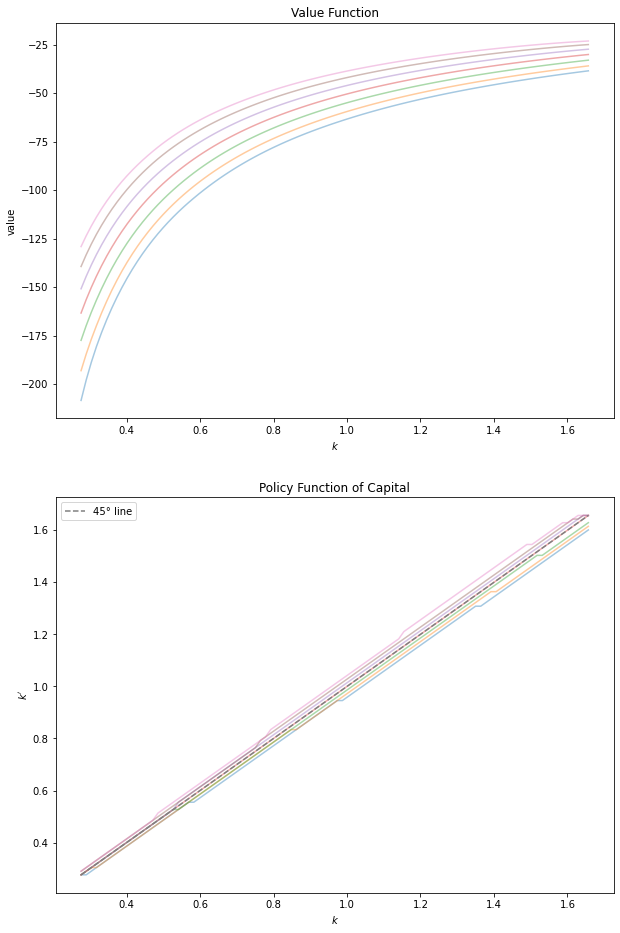

In [6]:
# guess of v
v0 = np.empty((naa, nkk))
for i, A in enumerate(A_array):
    v0[i,:] = np.log(k_grid)

u_tensor = flow_util(γ, θ, A_array)
u_tensor
# solve for the vf/pf
v_star, k1_idx = VFI(v0, β, PA, u_tensor)
k1_star = k_grid[k1_idx]

# plot
fig1, axes = plt.subplots(2, 1, figsize=(10, 16))
for i in range(naa):
        axes[0].plot(k_grid, v_star[i,:], alpha=0.4)
        axes[1].plot(k_grid, k1_star[i,:], alpha=0.4)

axes[0].set_xlabel('$k$')
axes[0].set_ylabel('value')

axes[1].set_xlabel('$k$')
axes[1].set_ylabel('$k^{\prime}$')

axes[0].set_title('Value Function')
axes[1].set_title('Policy Function of Capital')
axes[1].plot(k_grid, k_grid, label='45° line', ls='--')
axes[1].legend()


Simulate exogenous shock A, then given the policy function, simulate the data.

In [7]:
@njit
def jitted_normal(N, seed, μ, σ):
    """
    ignore this function;
    just to circumvent the compilation problem.
    """
    with objmode(y="float64[::1]"):
        rng = np.random.default_rng(seed)
        y=rng.normal(loc=μ, scale=σ, size=N)
    return y

def _sim_shock(ρ_a, σ_a, mc_A, seed, sim_mc, t_length, burning):
    """
    simulate the shock of A,
    either simulate discrete MC, or simulate continuous AR(1) process;
    this is a helper function for the next function sim_data.

    * ρ_a, σ_a, mc_A: parameters/MC object for A process
    """
    if sim_mc is True:
        # simulate MC, discrete
        A_idx = mc_A.simulate_indices(t_length+burning+1, random_state=seed)
        A_series = A_array[A_idx]
        return A_series, A_idx
    else:
        # simulate AR1, continuous
            #the i.i.d shock for A process
        ϵ_array = jitted_normal(t_length+burning, seed=seed, μ=0, σ=σ_a)

            #assume log(A) follows AR(1)
        A_series = np.empty(t_length+burning+1)
        A_series[0] = 0
        for t in range(t_length+burning):
            A_series[t+1] = ρ_a * A_series[t] + ϵ_array[t]

        A_series = np.exp(A_series)
        return A_series

def sim_data(k1_idx, k1_star, ρ_a, σ_a, mc_A, θ, seed, sim_mc=True, t_length=1000):
    """
    simulate the data given the policy function and the exogenous shock.
    allow for a burning period of 20 periods

    * k1_idx: policy function of k', index rather than value
    * k1_star: policy function of k'
    * ρ_a, σ_a, mc_A: parameters/MC object for A process
    * θ: needed for the simulation of employment
    """
    burning = 20 # burning period
    if sim_mc is True: # simulate the shock as MC, discrete
        A_series, A_idx = _sim_shock(ρ_a, σ_a, mc_A, seed, sim_mc, t_length, burning)

        # preallocate capital series
        k_data_idx = np.empty(t_length+burning+1, dtype=np.int8)
        k_data_idx[0] = 0

        # simulate the capital series, discrete
        for t in range(t_length+burning):
            iA = A_idx[t]
            ik = k_data_idx[t]
            k_data_idx[t+1] = k1_idx[iA,ik]
        k_data = k_grid[k_data_idx]

    else: # simulate the shock as AR1, continuous
        A_series = _sim_shock(ρ_a, σ_a, mc_A, seed, sim_mc, t_length, burning)

        # preallocate capital series
        k_data = np.empty(t_length+burning+1)
        k_data[0] = k_grid[0]

        # need to interpolate the capital policy function
            #2d interpolation, policy function of capital
        grid = (A_array, k_grid)
        k1_func = lambda ak: eval_linear(grid, k1_star, ak)
        # evaluate the function recursively to get the capital series
        for t in range(t_length+burning):
            akv = np.array([A_series[t], k_data[t]])
            k_data[t+1] = k1_func(akv)

    # employment, production, consumption and investment are functions of A and k
    n_data = np.zeros(t_length+burning+1)
    y_data = np.zeros(t_length+burning+1)
    c_data = np.zeros(t_length+burning+1)
    i_data = np.zeros(t_length+burning+1)
    for t in range(1, t_length+burning):
        n = n_star(k_data[t], A_series[t], θ)
        y = f_func(k_data[t], n, A_series[t])
        c = c_func(k_data[t+1], k_data[t], n, A_series[t])
        n_data[t], y_data[t], c_data[t] = n, y, c
        i_data[t] = y - c

    return {'output': y_data[-t_length-1:-1], 'capital': k_data[-t_length-1:-1], \
            'employment': n_data[-t_length-1:-1], \
            'consumption': c_data[-t_length-1:-1], 'investment': i_data[-t_length-1:-1]}


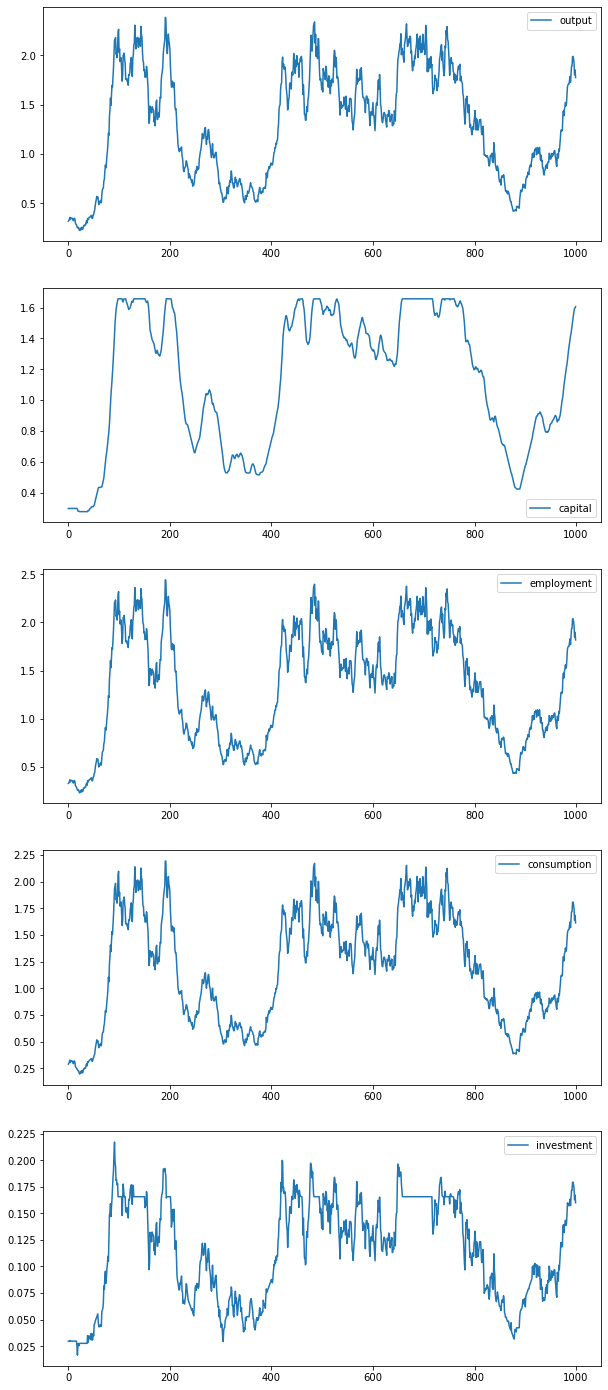

In [8]:
# simulate the actual data, continuously
rbc_data = sim_data(k1_idx, k1_star, ρ_a, σ_a, mc_A, θ, seed=1234, sim_mc=False, t_length=1000)

fig, axes = plt.subplots(5,1, figsize=(10,25))
var_names = rbc_data.keys()
var_datas = rbc_data.values()

for name, data, ax in zip(var_names, var_datas, axes):
    ax.plot(data, label=name)
    ax.legend()


# Step 2
estimation outside the dynamic programming loop

A series is deducted from y,k,n since we know α. The process can be estimated using AR(1).

θ is estimated from FOC for labor.


In [9]:
def est_outloop(rbc_data):
    y_data, k_data, n_data, c_data, i_data = rbc_data.values()
    t_length = y_data.size

    # estimate the process of A. We already know α, so A series can be deducted.
    A_data = np.empty_like(y_data)

    for t in range(t_length):
        A_data[t] = y_data[t] / ((k_data[t] ** (1 - α)) * (n_data[t] ** α))

    logA_data = np.log(A_data)

        # run AR(1) model to estimate the process of A
    res = AutoReg(logA_data, lags=1, trend='n', old_names=False).fit()
    ρ_hat, = res.params
        # use the residual to estimate σ for the processes
    resid = res.resid
    σ_hat = np.sqrt(1 / (len(resid) - 1) * resid @ resid)

    # estimate θ from the FOC for labor (taking the averages over all the periods)
    θ_hat = np.mean((k_data / n_data) ** (1 - α) * A_data * α)

    return ρ_hat, σ_hat, θ_hat

ρ_a_hat, σ_a_hat, θ_hat = est_outloop(rbc_data)
print(f"1. The estimated ρ_a and σ_a are {ρ_a_hat:.4f} and {σ_a_hat:.4f}, respectively.")
print(f"2. The estimated θ is {θ_hat:.4f}")


1. The estimated ρ_a and σ_a are 0.9171 and 0.0101, respectively.
2. The estimated θ is 0.7800


# Step 3: SMM


In [11]:
# moments: from VAR(2)
def est_moments(rbc_data):
    y_data, i_data = rbc_data['output'], rbc_data['investment']
    data = pd.DataFrame(np.array([y_data, i_data]).T, columns=['output', 'investment'])
    res = VAR(data).fit(2, trend='n')
    #return res.coefs, res.resid_corr
    return np.concatenate((res.coefs.flatten(), res.resid_corr.flatten()))

# data moments obtained from the data
mm_dt = est_moments(rbc_data)

# for a give (β, γ), solve the problem and get the simulated moments
def sim_moments(β0, γ0, ρ_a_hat, σ_a_hat, θ_hat, T, seed):
    "mapping from parameters to simulated moments"
    # take θ, ρ_a, σ_a as the estimated value from step 2
    mc_A_hat = tauchen(ρ_a_hat, σ_a_hat, m=2, n=naa)
    A_array_hat, PA_hat = mc_A_hat.state_values, mc_A_hat.P
    A_array_hat = np.exp(A_array_hat)

    # given β0 and γ0, solve the DGP
    u_tensor = flow_util(γ0, θ_hat, A_array_hat)

    v0 = np.ones((naa, nkk))
    v_star, k1_idx = VFI(v0, β0, PA_hat, u_tensor)
    k1_star = k_grid[k1_idx]

    # simulate the data and run VAR(2) to obtain the simulated moments
    rbc_sim = sim_data(k1_idx, k1_star, ρ_a_hat, σ_a_hat, mc_A_hat, θ_hat, seed, sim_mc=True, t_length=T)
    mm_sim = est_moments(rbc_sim)

    return mm_sim

def Jfunc(params, ρ_a_hat, σ_a_hat, θ_hat, W, T, seed=4321):
    """
    criterion function that need to be minimized.
    set seed, so for each guess of β, we are using the same simulated shock.

    * params: (β0, γ0), as a list of arguments to pass in function sim_moments
    * W: weighting matrix
    * T: simulated sample size
    """
    mm_sim = sim_moments(*params, ρ_a_hat, σ_a_hat, θ_hat, T, seed)

    return (mm_sim - mm_dt) @ W @ (mm_sim - mm_dt)


Text(0.5, 0, 'criterion function')

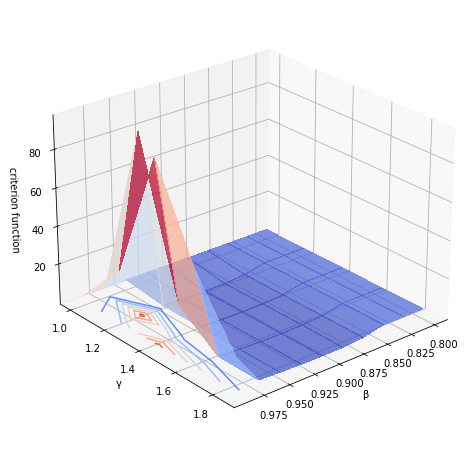

In [12]:
# use idendity matrix as weighting matrix
num_mm = mm_dt.size
I_mat = np.eye(num_mm)
T_sim = 10_000

# plot the criterion function before minimization
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

β_array = np.linspace(0.80, 0.99, 10)
γ_array = np.linspace(1.0, 1.85, 5)
J_array = np.zeros((10, 5))
for i in range(10):
    for j in range(5):
        params = (β_array[i], γ_array[j])
        J_array[i,j] = Jfunc(params, ρ_a_hat, σ_a_hat, θ_hat, I_mat, T_sim)

bb, gg = np.meshgrid(β_array, γ_array)

fig_J, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,8))
ax.plot_surface(bb, gg, J_array.T, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.7)
ax.contour(bb, gg, J_array.T, zdir='z', offset=0, cmap=cm.coolwarm)
ax.view_init(25, 50)
ax.set_xlabel('β')
ax.set_ylabel('γ')
ax.set_zlabel('criterion function')


In [15]:
# minimization. now it's two dimensional.
x0 = (0.8, 1.7)
bnds = ((0.70, 0.99), (1.0, 2.0))
tol = 1e-5
opt={'maxiter': 10_00, 'disp': False}
params_ssm = optimize.minimize(Jfunc, x0, args=(ρ_a_hat, σ_a_hat, θ_hat, I_mat, T_sim), method='Powell',
                               bounds=bnds, options=opt, tol=tol)

print(f"The estimate of β and γ are {params_ssm.x[0]:.4f} and {params_ssm.x[1]:.4f}, respectively. \
          The true value of β and γ are {β} and {γ}.")

The estimate of β and γ are 0.9082 and 1.6398, respectively.           The true value of β and γ are 0.89 and 1.8.
